In [ ]:
# !pip install bridson

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from mpl_toolkits import mplot3d

#### Visualizing the difference between Random and Bridson Fast Poisson disc distribution algorithm
- Bridson algorithm generates between 2 borders (height and width) a set of points with a spacing.

##### Random.

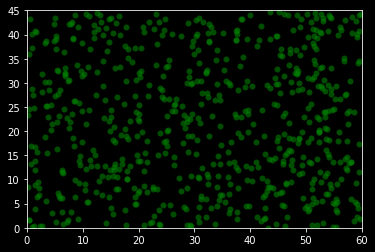

In [2]:
plt.style.use("dark_background")

width, height = 60, 45
N = int(width * height / 4)
plt.scatter(np.random.uniform(0,width,N), np.random.uniform(0,height,N),
            c='g', alpha=0.6, lw=0)
plt.xlim(0,width)
plt.ylim(0,height)
plt.show()

##### Bridson F-PDS distribution

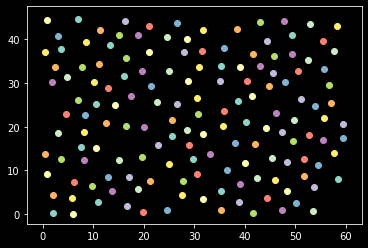

In [3]:
from bridson import poisson_disc_samples
for i in poisson_disc_samples(60,45,3):
    plt.scatter(i[0],i[1])

#### Sampling using Dart Throwing/PDS strategy on a Toy DataSet.
- Generate a circular dataset (aesthetics reason).
- Implement 2 algorithms:
    - Exhaustive search
    - Preset N-Samples.

In [4]:
length = np.sqrt(np.random.uniform(0, 1,500))
angle = np.pi * np.random.uniform(0, 2,500)

x = length * np.cos(angle)
y = length * np.sin(angle)


In [5]:
new_length = np.append(length,-length)
x_new = np.append(x,x)
y_new = np.append(y,y)
new_length.shape

(1000,)

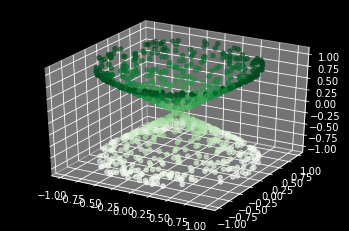

In [6]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(x_new, y_new, new_length,c=new_length, cmap='Greens');

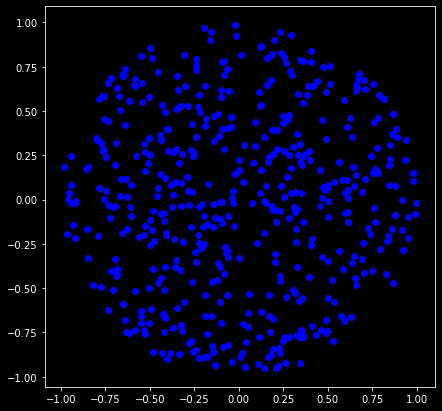

In [7]:
plt.figure(figsize=(7,7))
plt.scatter(x,y,color="blue")
plt.show()

In [8]:
# To be used later on for the algorithm optimization in case it was approved.
from scipy.spatial import cKDTree

In [9]:
X = pd.Series(x,name="X")
Y = pd.Series(y,name="Y")

In [10]:
df = pd.concat([X,Y],axis=1)
df.head()

,X,Y
0,-0.478721,-0.067189
1,-0.240773,0.757583
2,-0.369861,-0.723507
3,-0.548567,-0.696972
4,0.118232,0.035560


#### Implementation and Pseudo Code.
- Choose a random point from the space.
- Iterate while the N samples haven't been found or the data haven't ended.
    - Check if the new sampled point respects the distance constraint
    - if it does, keep it.
    - if it doesn't refute it.
    - Remove the data from the dataset
- End when the N samples have been found or the data is empty

In [11]:
def new_points(X,Y,indexes):
    """
    Draws the original data set and the sampled points and highlights them.
    
    """
    plt.figure(figsize=(10,10))
    plt.scatter(X[indexes],Y[indexes],color="yellow",s=100,alpha=0.8,label = "Sampled Points")    
    plt.scatter(X,Y,color="blue",alpha=1,label="Original data",s=1)
    plt.legend()
    plt.show()

In [12]:
def euclid_dist(row1,row2):
    """
    Calculates the euclidean distance.
    """
    return np.sqrt(np.sum((row1-row2)**2))

In [13]:
# def check_index(new_point_index,index_holder):
#     if new_point_index in index_holder:
#         return index_holder
#     else:
#         index_holder.append(new_point_index)
#         return index_holder

In [14]:
def value_point(data,index):
    """
    Turns the rows of a dataframe into an array, to apply euclidean distance easily.
    """
    return data.iloc[index].values

In [15]:
def check_euclidean(data,new_point_index,index_holder,radius):
    """
    Checks if the new sampled point (new_point_index) respects the distance constraint (radius) 
    against all the other previously sampled points (index_holder) one point at a time.
    
    ##Note## Could be a better way to do this search to make it faster.
    
    """
    for i in index_holder:
        # calculate the euclidean distance between the reference point and the already set indexes
        # if distance less than preset radius it breaks and refutes the point
        if euclid_dist(value_point(data,new_point_index),value_point(data,i)) <= radius:
            return index_holder
    index_holder.append(new_point_index)
    return index_holder

### N-Samples Poisson.
- Keeps running until N points have been sampled or when data contains no more points.
- Speed can be reduced by applying optimized nearest neighbors algorithms.
    - KDTree
    - Ball tree

In [16]:
def apply_poisson(data,n_samples,radius):
    """
    Performs the poisson algorithm.
    """
    # contains a random starting point index
    index_holder = [data.sample(1).index[0]]
    # copy of the data
    data_copy = data.copy()
    # drop the row that was sampled from the data
    data_copy.drop(index_holder[0],axis=0,inplace=True)
    # while the required N-samples not found keep looping and the data is not empty
    # The condition was softened to avoid having errors in case N data points werent sampled
    # Hard condition : While(len(index_holder) != n_samples):  only
    while(len(index_holder) < n_samples) and (len(data_copy) != 0):
        # sampling new random point
        new_datapoint = data_copy.sample(1)
        # take the index
        new_point_index = new_datapoint.index[0]
        # check if the index is already in the index list
        index_holder = check_euclidean(data,new_point_index,index_holder,radius)
        # drop the new sampled point from the data
        data_copy.drop(new_point_index,axis=0,inplace=True)
    return index_holder

### Exhaustive Poisson.
- Keeps running until all dataset is covered.
- Sampling can be discarded, however, it is kept to get different distributions on every run.
- Speed can be improved if KDTree algorithm is integrated in it.
    - After Sampling a point, apply KDTree
    - Remove all given indexes by KDTree for this point from the dataset
- Speed can be improved if BallTree algorithm is used.

In [17]:
def apply_poisson_exhaustive(data,radius):
    # contains a random point index
    index_holder = [data.sample(1).index[0]]
    data_copy = data.copy()
    # drop the row that was sampled
    data_copy.drop(index_holder[0],axis=0,inplace=True)
    # while the required datasamples not found keep looping
    while(len(data_copy) != 0):
        # sampling new random point
        new_datapoint = data_copy.sample(1)
        # take the index
        new_point_index = new_datapoint.index[0]
        # check if the index is already in the index list
        index_holder = check_euclidean(data,new_point_index,index_holder,radius)
        # drop the new sampled point from the data
        data_copy.drop(new_point_index,axis=0,inplace=True)
    return index_holder

### Timing for the algorithms.
- Visualizing the time over multiple iterations.

##### Poisson N samples.

In [18]:
# start_time = time.time()
# indexes = apply_poisson(df,80,0.1)
# print("--- %s seconds ---" % (time.time() - start_time))

##### Poisson Exhaustive.

In [19]:
# import time
# start_time = time.time()
# indexes_exhaustive = apply_poisson_exhaustive(df,0.1)
# print("--- %s seconds ---" % (time.time() - start_time))

In [20]:
# new_points(X,Y,indexes_exhaustive)

In [21]:
# list_times = []
# for i in range(50):
#     start_time = time.time()
#     indexes_exhaustive = apply_poisson_exhaustive(df,0.1)
#     list_times.append(time.time()-start_time)

In [22]:
# plt.plot(list_times)

In [23]:
# list_times_nonex = []
# for i in range(1,100):
#     start_time = time.time()
#     indexes = apply_poisson(df,i,0.1)
#     list_times_nonex.append(time.time()-start_time)


In [24]:
# plt.plot(list_times_nonex)

In [25]:
indexes_100 = apply_poisson(df,100,0.1)

In [26]:
indexes_random_sampling = list(df.sample(100).index)

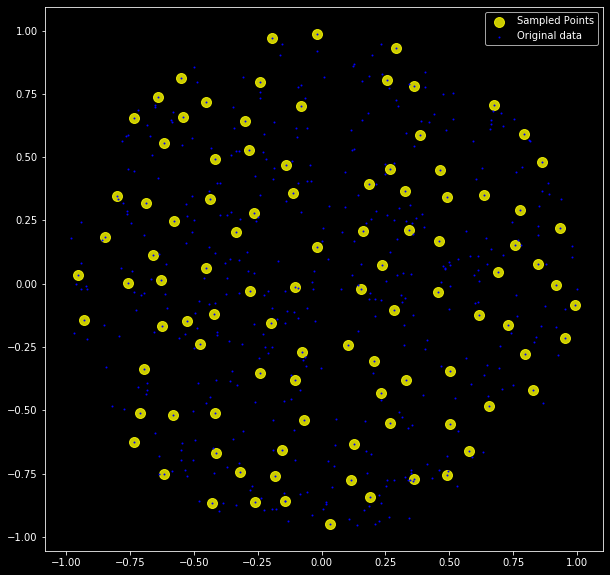

In [27]:
new_points(X,Y,indexes_100)

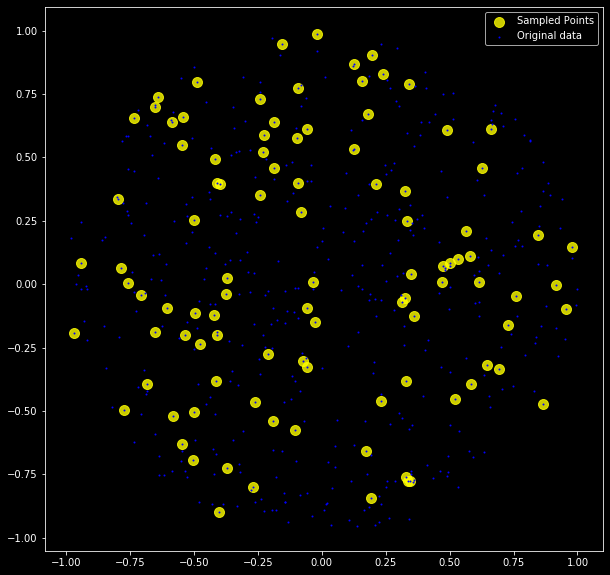

In [28]:
new_points(X,Y,indexes_random_sampling)

In [29]:
indexes_500 = apply_poisson(df,500,0.1)

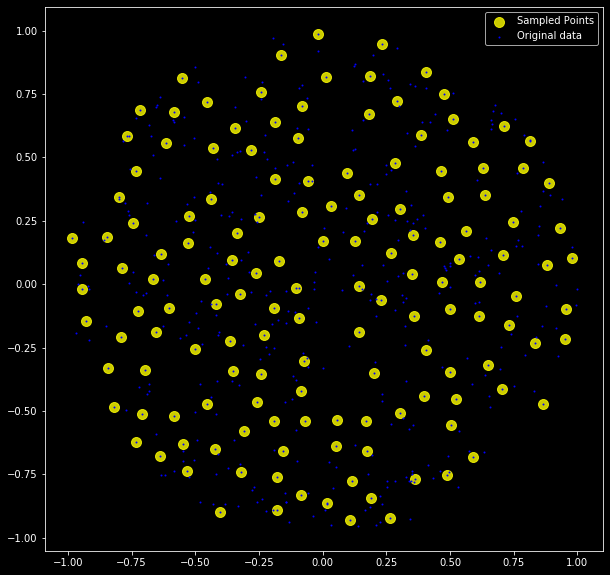

In [30]:
new_points(X,Y,indexes_500)

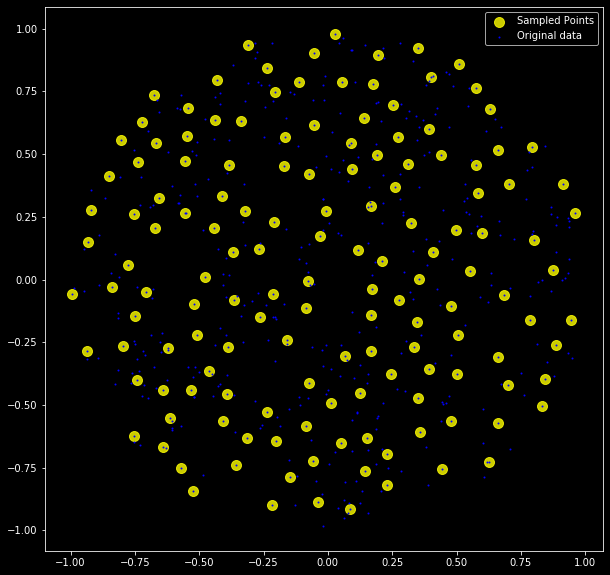

In [29]:
indexes_250 = apply_poisson(df,250,0.1)
new_points(X,Y,indexes_250)

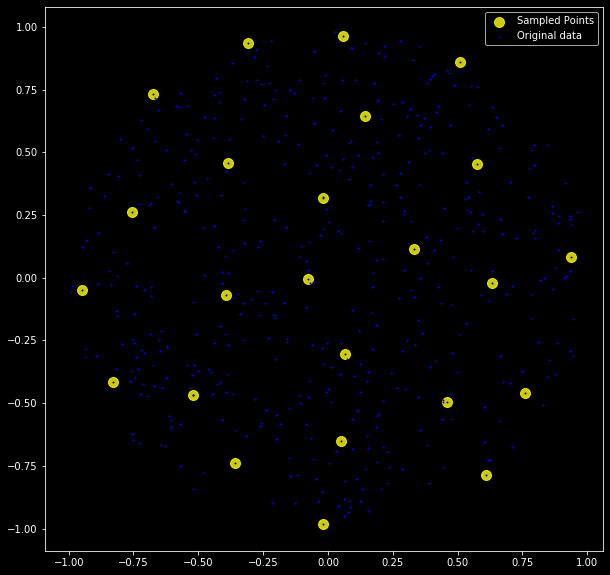

In [30]:
indexes_30 = apply_poisson(df,30,0.3)
new_points(X,Y,indexes_30)

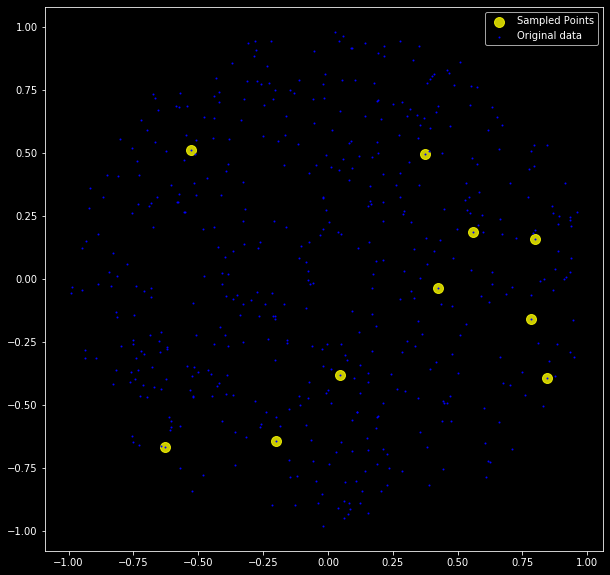

In [31]:
indexes_10 = apply_poisson(df,10,0.15)
new_points(X,Y,indexes_10)

### Implementing a different PDS-KDTree.
- Select a random point to start with.
- Check its N nearest neighbors 
    - Reject all NN within a certain radius
    - Valid point
        - Sample One of them
        

In [31]:
from scipy.spatial import cKDTree

In [32]:
def get_nearest_neighbors(tree,data,point_index_toquery,radius):
    results_query = tree.query(data.iloc[point_index_toquery],k=100,p=2,distance_upper_bound = radius)
    # query filtered for point indexes to drop, on the distances that are less than infinity
    index_to_drop = results_query[1][results_query[0]<np.inf][1:]
    
    return list(index_to_drop)

In [33]:
import time
# start_time = time.time()
# tree = cKDTree(df,leafsize=40)
# print("--- %s seconds ---" % (time.time() - start_time))

In [34]:
def apply_poisson_KDTree(data,n_samples,radius):
    """
    Performs the poisson algorithm.
    """
    # initialize a tree
    mytree = cKDTree(data, leafsize=40)
    # contains a random starting point index
    index_holder = [data.sample(1).index[0]]
    # copy of the data
    data_copy = data.copy()
    # indexes to drop found by kdtree
    index_todrop = get_nearest_neighbors(mytree,data,index_holder[0],radius)
    # drop the row that was sampled from the data
    data_copy.drop(index_holder[0],axis=0,inplace=True)
    # drop the nearest neighbors found by the tree
    data_copy.drop(index_todrop,axis=0,inplace=True)
    
    # while the required N-samples not found keep looping and the data is not empty
    # The condition was softened to avoid having errors in case N data points werent sampled
    # Hard condition : While(len(index_holder) != n_samples):  only
    
    
    while(len(index_holder) < n_samples) and (len(data_copy) != 0):
        # sampling new random point
        new_datapoint = data_copy.sample(1)
        # take the index
        new_point_index = new_datapoint.index[0]
        # variable containing index_holder length 
        len_index_holder = len(index_holder)

        # check if the index is already in the index list
        index_holder = check_euclidean(data,new_point_index,index_holder,radius)

        # drop the new sampled point from the data
        data_copy.drop(new_point_index,axis=0,inplace=True,errors='ignore')
        # if different length, means index holder got a new point added 
        if len(index_holder) != len_index_holder:
            # generate the nearest points of the new datapoint
            index_todrop = get_nearest_neighbors(mytree,data,new_point_index,radius)
            data_copy.drop(index_todrop,axis=0,inplace=True,errors='ignore')
    return index_holder

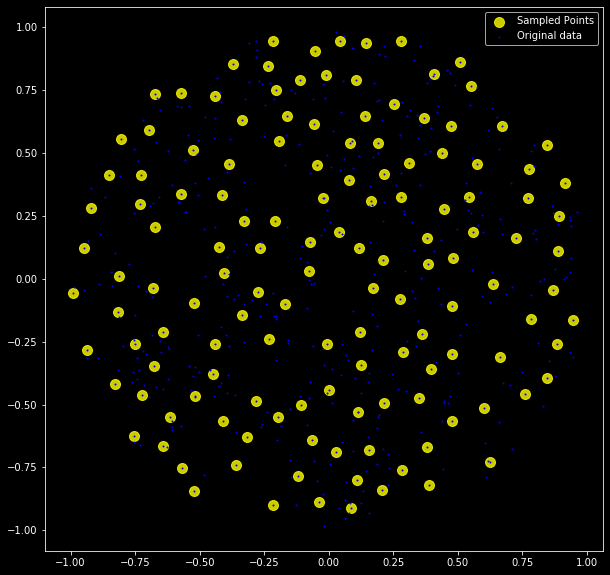

In [112]:
indexes_KDTree = apply_poisson_KDTree(df,500,0.1)
new_points(X,Y,indexes_KDTree)

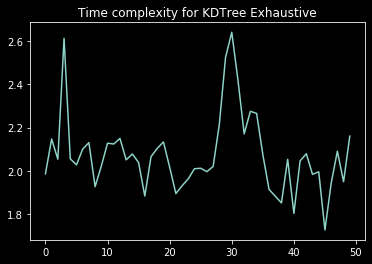

In [114]:
# list_times_exhaustiveKD = []
# for i in range(50):
#     start_time = time.time()
#     indexes_exhaustive_KD = apply_poisson_KDTree(df,500,0.1)
#     list_times_exhaustiveKD.append(time.time()-start_time)
# plt.title("Time complexity for KDTree Exhaustive")
# plt.plot(list_times_exhaustiveKD)

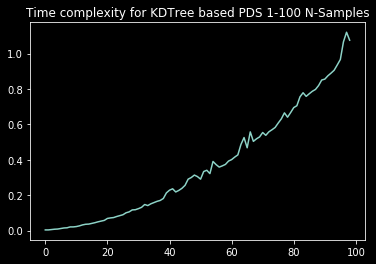

In [113]:
# list_times_KDTree = []
# for i in range(1,100):
#     start_time = time.time()
#     indexes = apply_poisson_KDTree(df,i,0.1)
#     list_times_KDTree.append(time.time()-start_time)
# plt.title("Time complexity for KDTree based PDS 1-100 N-Samples")
# plt.plot(list_times_KDTree)
# plt.show()

### Time complexity based on sample size.

In [56]:
def generate_and_test(n):
    length = np.sqrt(np.random.uniform(0, 1,n))
    angle = np.pi * np.random.uniform(0, 2,n)
    # circular data points generation
    x = length * np.cos(angle)
    y = length * np.sin(angle)
    # turn to series
    X = pd.Series(x,name="X")
    Y = pd.Series(y,name="Y")
    # turn to dataframe
    df = pd.concat([X,Y],axis=1)
    start_time = time.time()
    indexes_holder = apply_poisson_exhaustive(df,0.1)
    time_spent = time.time()-start_time
    return X,Y,time_spent,indexes_holder

In [58]:
def generate_and_test_kd(n):
    length = np.sqrt(np.random.uniform(0, 1,n))
    angle = np.pi * np.random.uniform(0, 2,n)
    # circular data points generation
    x = length * np.cos(angle)
    y = length * np.sin(angle)
    # turn to series
    X = pd.Series(x,name="X")
    Y = pd.Series(y,name="Y")
    # turn to dataframe
    df = pd.concat([X,Y],axis=1)
    start_time = time.time()
    indexes_holder = apply_poisson_KDTree(df,n,0.1)
    time_spent = time.time()-start_time
    return X,Y,time_spent,indexes_holder

In [41]:
import time

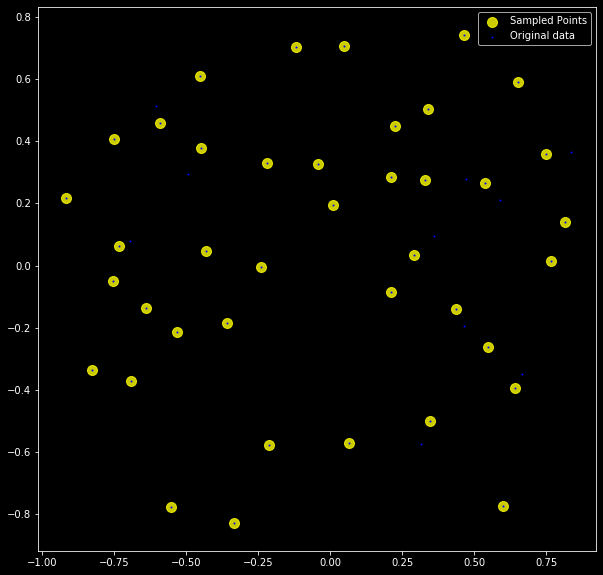

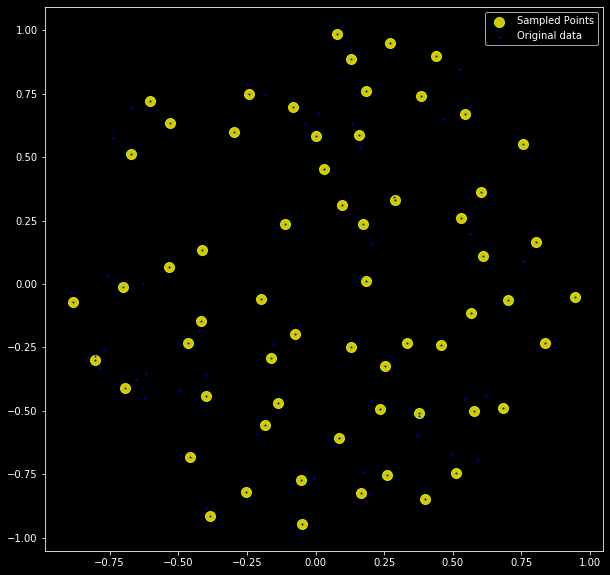

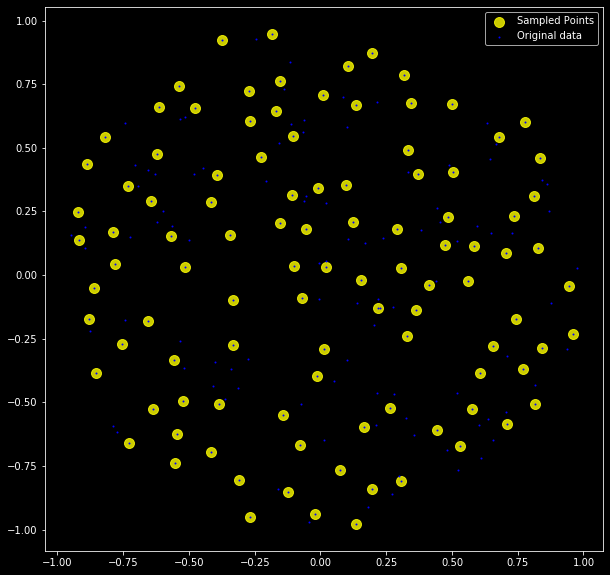

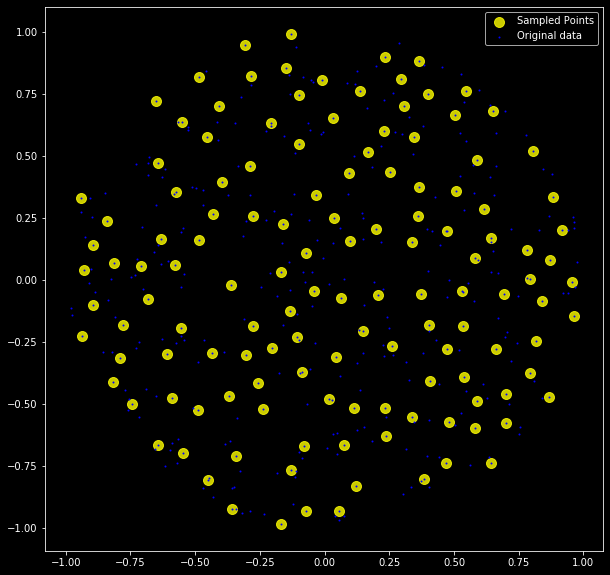

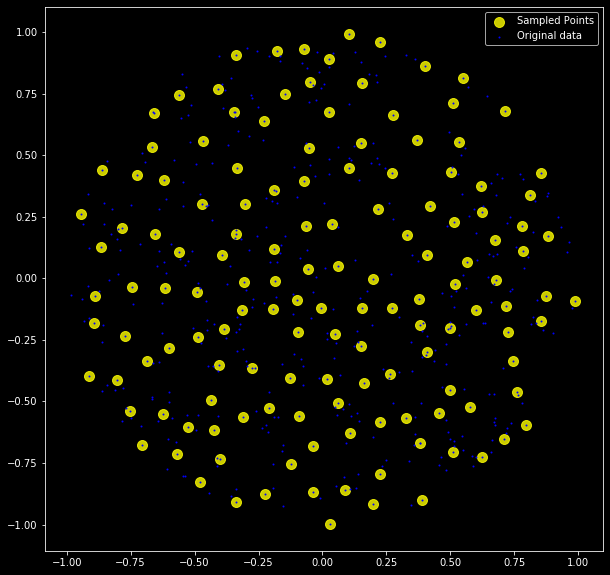

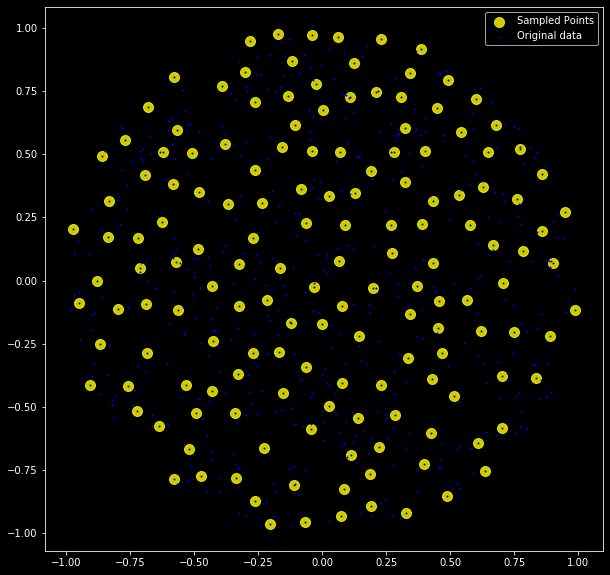

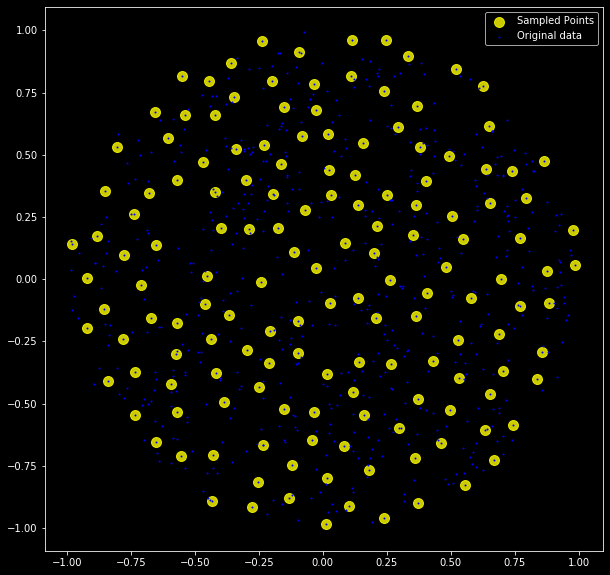

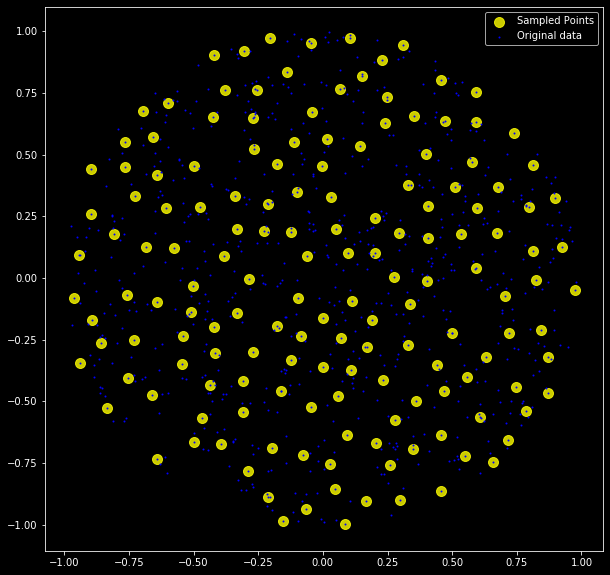

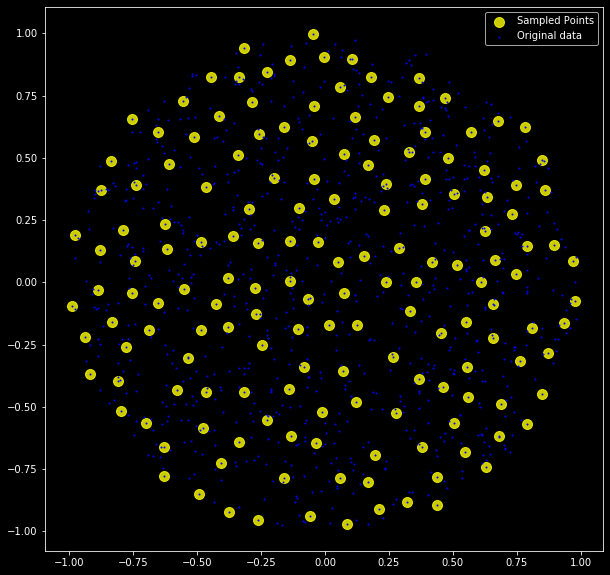

In [43]:
collect_times = []
for i in [50,100,200,400,500,600,700,800,1000]:
    X,Y,time_spent,indexes_holder = generate_and_test(i)
    new_points(X,Y,indexes_holder)
    collect_times.append(time_spent)    

Text(0.5, 0, 'N samples')

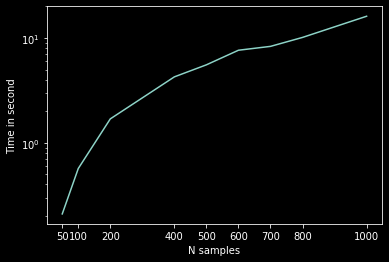

In [54]:
plt.plot([50,100,200,400,500,600,700,800,1000],collect_times)
plt.xticks([50,100,200,400,500,600,700,800,1000])
plt.ylabel("Time in second")
plt.yscale("log")
plt.xlabel("N samples")

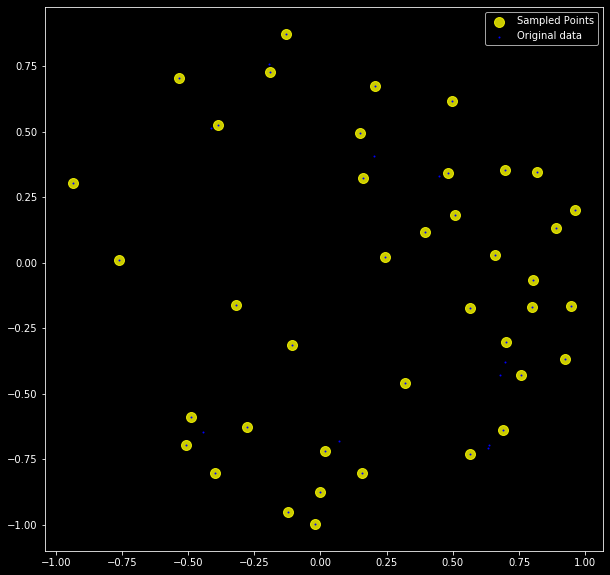

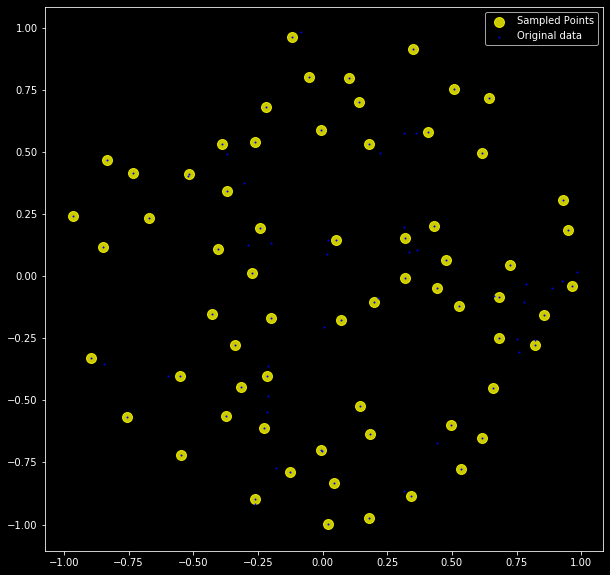

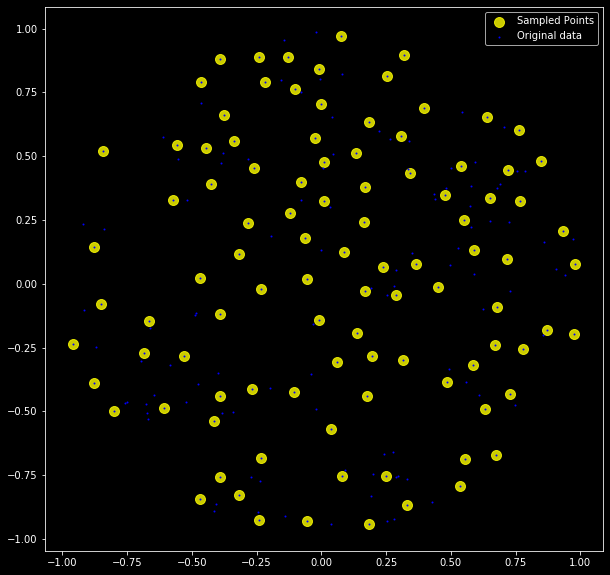

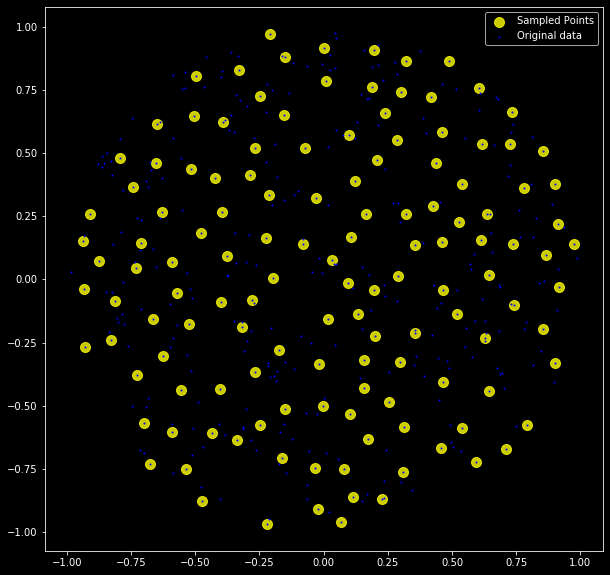

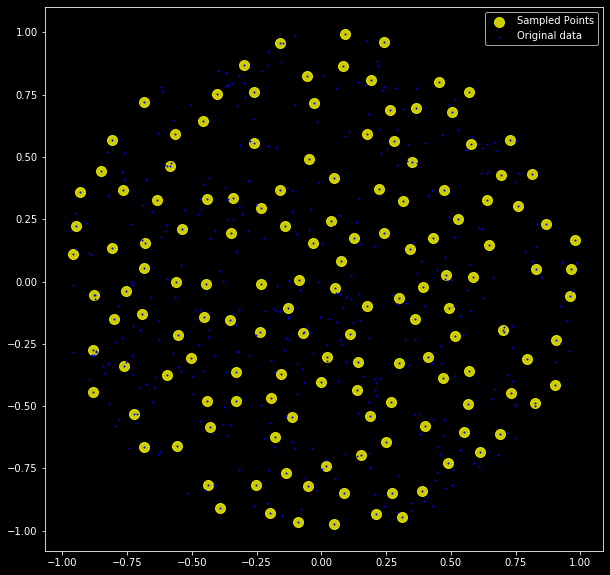

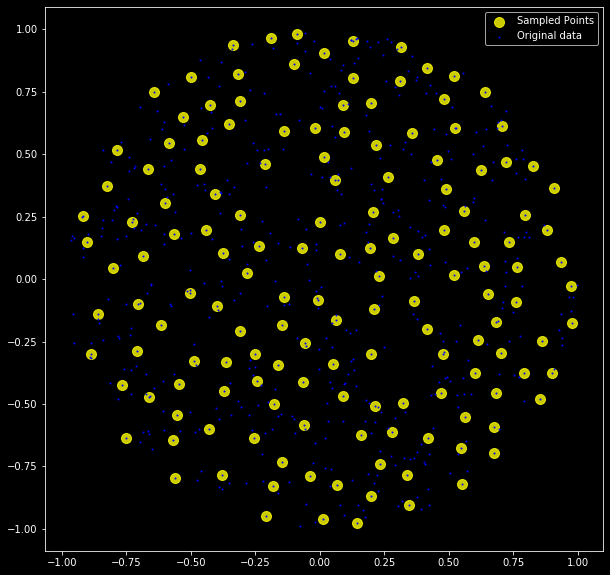

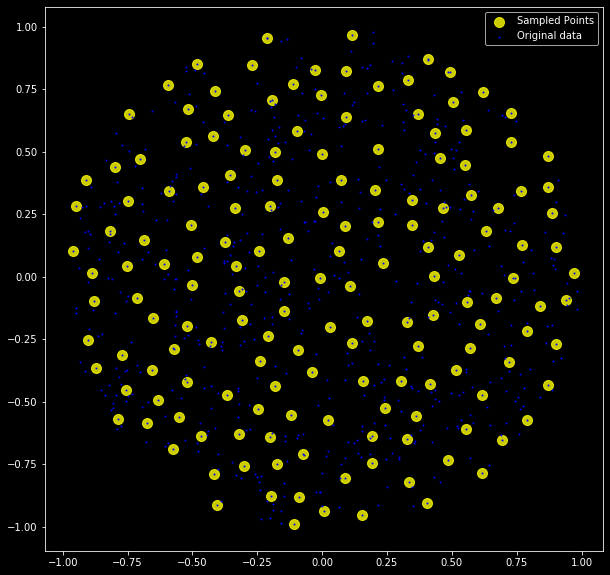

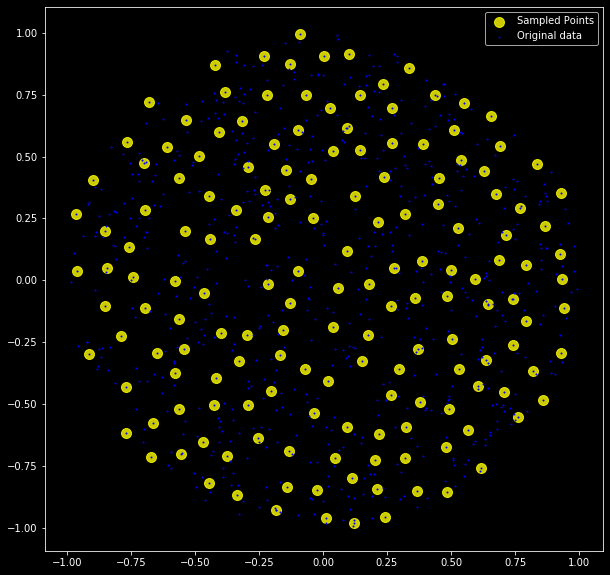

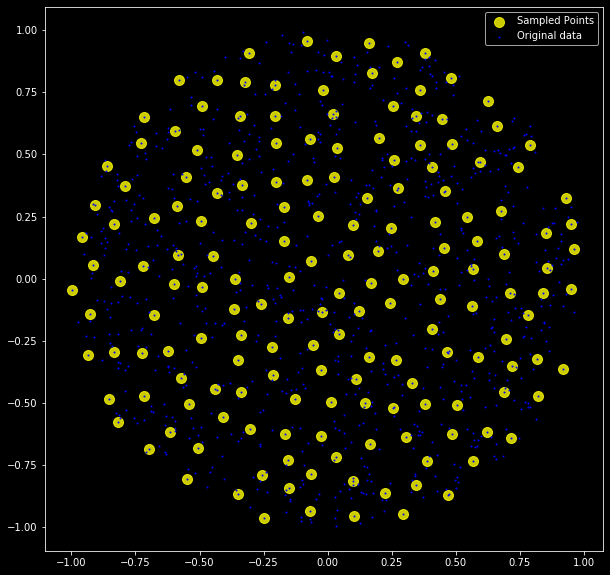

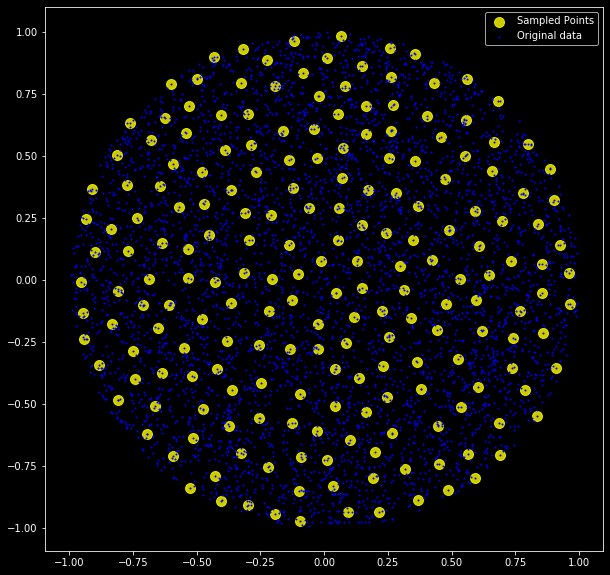

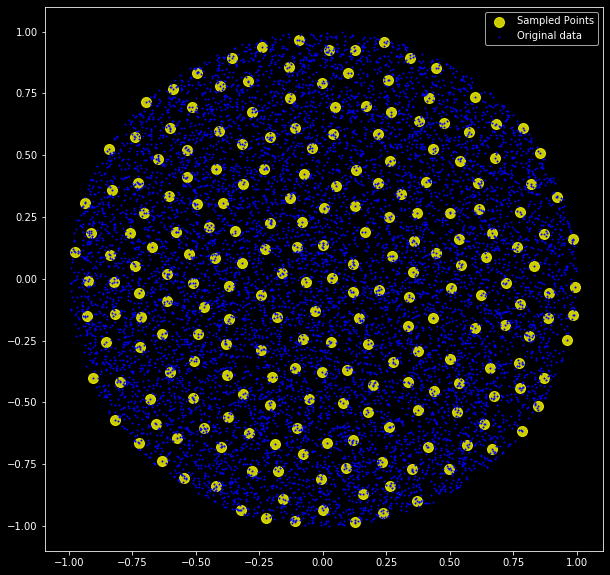

In [59]:
collect_times_kd = []
for i in [50,100,200,400,500,600,700,800,1000,5000,10000]:
    X,Y,time_spent,indexes_holder = generate_and_test_kd(i)
    new_points(X,Y,indexes_holder)
    collect_times_kd.append(time_spent)   

Text(0.5, 0, 'N samples')

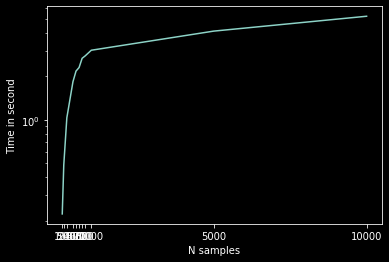

In [60]:
plt.plot([50,100,200,400,500,600,700,800,1000,5000,10000],collect_times_kd)
plt.xticks([50,100,200,400,500,600,700,800,1000,5000,10000])
plt.ylabel("Time in second")
plt.yscale("log")
plt.xlabel("N samples")

In [61]:
def generate_and_test_kd_rad(n,radius):
    length = np.sqrt(np.random.uniform(0, 1,n))
    angle = np.pi * np.random.uniform(0, 2,n)
    # circular data points generation
    x = length * np.cos(angle)
    y = length * np.sin(angle)
    # turn to series
    X = pd.Series(x,name="X")
    Y = pd.Series(y,name="Y")
    # turn to dataframe
    df = pd.concat([X,Y],axis=1)
    start_time = time.time()
    indexes_holder = apply_poisson_KDTree(df,n,radius)
    time_spent = time.time()-start_time
    return X,Y,time_spent,indexes_holder

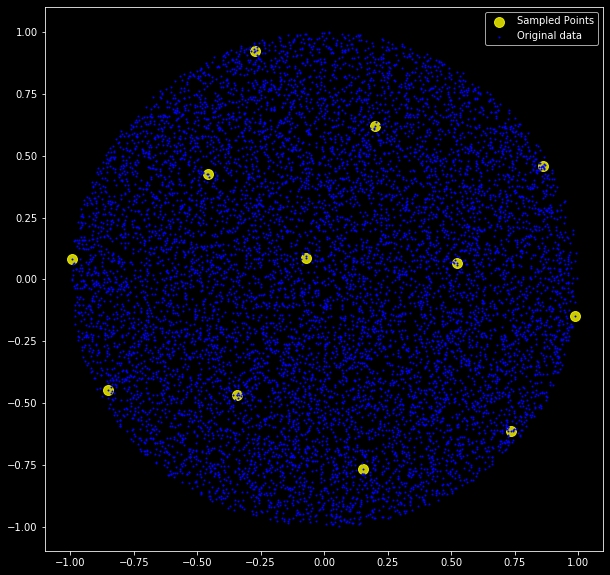

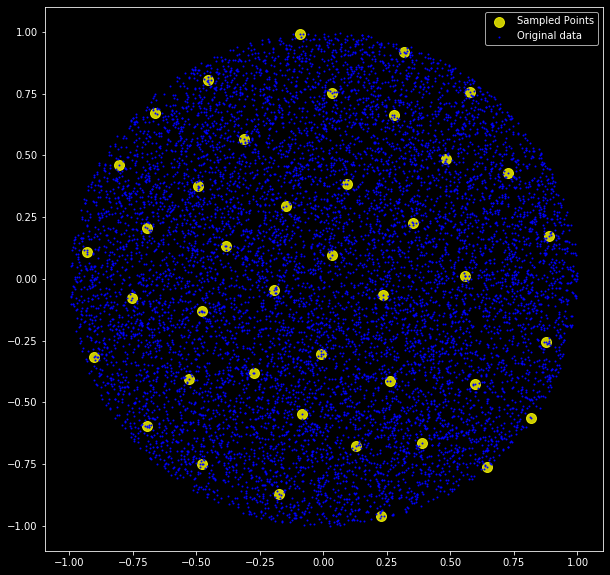

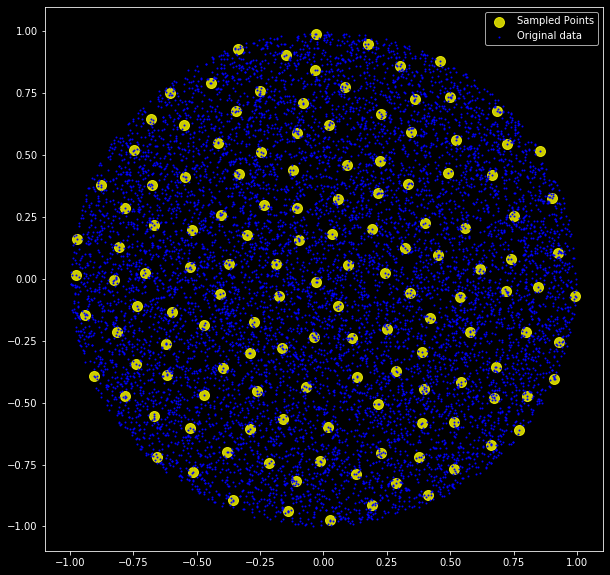

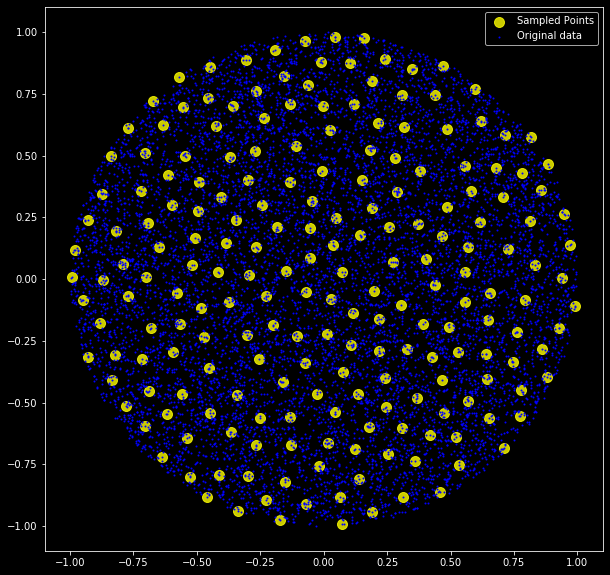

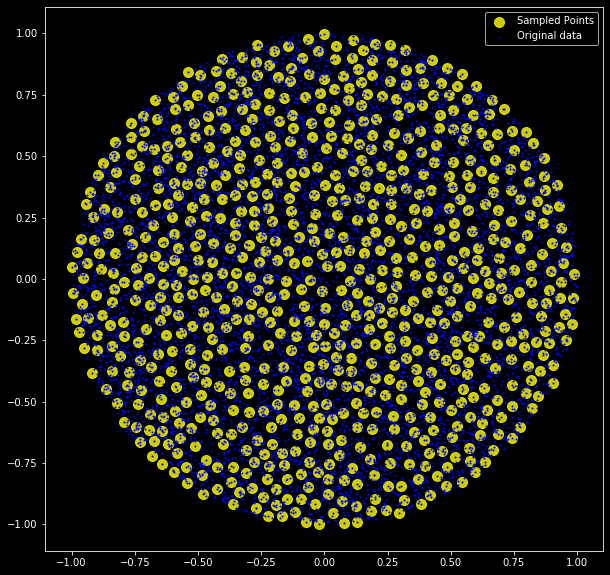

KeyboardInterrupt: 

In [63]:
collect_times_kd_rad = []
for i in [0.5,0.25,0.125,0.1,0.05,0.02]:
    X,Y,time_spent,indexes_holder = generate_and_test_kd_rad(10000,i)
    new_points(X,Y,indexes_holder)
    collect_times_kd_rad.append(time_spent)
plt.plot(collect_times_kd_rad)

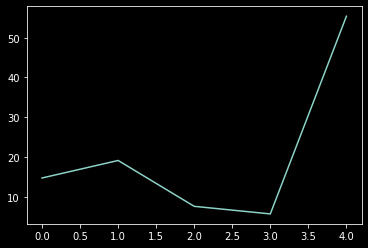

In [65]:
plt.plot(collect_times_kd_rad)

In [73]:
start_time = time.time()
X,Y,time_spent,indexes_holder = generate_and_test_kd_rad(10000,0.2)
print("--- %s seconds ---" % (time.time() - start_time))

--- 18.151926517486572 seconds ---


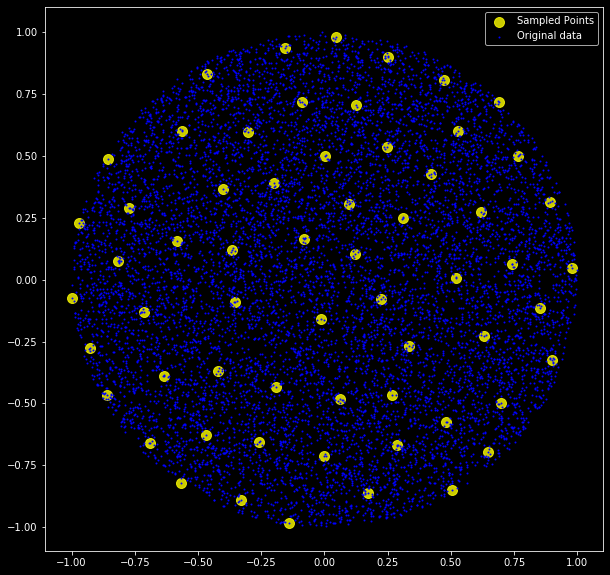

In [74]:
new_points(X,Y,indexes_holder)